In [2]:
import zipfile
import os

In [1]:
def extract_zip(zip_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Giải nén thành công! Nội dung được lưu tại: {extract_to}")
    except zipfile.BadZipFile:
        print("Lỗi: File không phải là file zip hợp lệ.")
    except Exception as e:
        print("Đã xảy ra lỗi:", e)

In [3]:
zip_file_path = "../dataset/Face_Dataset.zip"
extract_to_path = "../dataset/Face_Dataset"

In [4]:
extract_zip(zip_file_path, extract_to_path)

Giải nén thành công! Nội dung được lưu tại: ../dataset/Face_Dataset


In [ ]:
import os                        # Thư viện hệ thống để làm việc với đường dẫn file, duyệt thư mục,...
import cv2                       # OpenCV: xử lý ảnh (đọc, chuyển đổi màu sắc,...)
import numpy as np               # NumPy: xử lý mảng số, tính toán hiệu quả trên dữ liệu ảnh dưới dạng mảng
import torch                     # PyTorch: framework để xây dựng và huấn luyện mô hình học sâu
from torch.utils.data import Dataset, DataLoader  # Các lớp tiện ích của PyTorch để tạo dataset và load dữ liệu theo batch
import albumentations as A       # Albumentations: thư viện tăng cường dữ liệu ảnh (data augmentation)
from albumentations.pytorch import ToTensorV2    # Chuyển đổi ảnh sang tensor, tích hợp cho PyTorch
import matplotlib.pyplot as plt  # Thư viện vẽ đồ thị, hiển thị ảnh


In [ ]:
if torch.cuda.is_available():
    print("PyTorch đang sử dụng GPU.")
    print("Số lượng GPU khả dụng:", torch.cuda.device_count())
    print("Tên GPU:", torch.cuda.get_device_name(0))
else:
    print("PyTorch không sử dụng GPU. Sử dụng CPU thay thế.")

In [5]:
def read_image(image_path):
    """
    Đọc ảnh từ file và chuyển đổi từ BGR sang RGB.
    """
    image = cv2.imread(image_path)   # Đọc ảnh từ file theo đường dẫn image_path
    if image is None:
        # Kiểm tra nếu ảnh không tồn tại, thông báo lỗi
        raise FileNotFoundError(f"Không tìm thấy ảnh: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Chuyển đổi không gian màu từ BGR (mặc định của OpenCV) sang RGB
    return image  # Trả về ảnh đã chuyển đổi


In [6]:
def read_mask(mask_path):
    """
    Đọc mask từ file dưới dạng ảnh xám và chuyển thành mask nhị phân.
    """
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)   # Đọc mask dưới dạng ảnh xám (grayscale)
    if mask is None:
        # Nếu file mask không tồn tại, ném ra lỗi
        raise FileNotFoundError(f"Không tìm thấy mask: {mask_path}")
    # Ngưỡng chuyển đổi mask: pixel > 128 => 255, còn lại = 0
    _, mask = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)
    return mask  # Trả về mask đã chuyển thành dạng nhị phân


In [7]:
def get_transforms(target_size=(256, 256)):
    """
    Định nghĩa các phép biến đổi đồng bộ cho ảnh và mask bằng Albumentations.
    """
    transform = A.Compose([
        A.Resize(target_size[0], target_size[1]),      # Thay đổi kích thước ảnh và mask về kích thước target_size
        A.HorizontalFlip(p=0.5),                         # Lật ảnh và mask theo chiều ngang với xác suất 50%
        A.Normalize(mean=(0.485, 0.456, 0.406),           # Chuẩn hóa ảnh: trừ trung bình theo kênh màu
                    std=(0.229, 0.224, 0.225)),           # Chuẩn hóa ảnh: chia cho độ lệch chuẩn theo kênh màu
        ToTensorV2()                                     # Chuyển đổi ảnh và mask sang tensor của PyTorch
    ])
    return transform  # Trả về các phép biến đổi đã cấu hình


In [1]:
def process_sample(img_path, mask_path, transform):
    """
    Đọc, tiền xử lý và chuyển đổi ảnh và mask thành tensor.
    """
    image = read_image(img_path)       # Đọc ảnh từ file sử dụng hàm read_image
    mask = read_mask(mask_path)          # Đọc mask từ file sử dụng hàm read_mask

    augmented = transform(image=image, mask=mask)  # Áp dụng các phép biến đổi đã thiết lập cho cả ảnh và mask
    image_tensor = augmented['image']    # Trích xuất tensor của ảnh sau biến đổi
    mask_tensor = augmented['mask']      # Trích xuất tensor của mask sau biến đổi
    # Đảm bảo mask nhị phân: giá trị > 0 chuyển thành 1, còn lại là 0.
    mask_tensor = (mask_tensor > 0).float()
    return image_tensor, mask_tensor  # Trả về tuple (ảnh tensor, mask tensor)

In [ ]:
class PratheepanDataset(Dataset):
    """
    Dataset custom cho Pratheepan với 2 nhóm: FacePhoto và FamilyPhoto.
    """
    def __init__(self, face_img_folder, face_mask_folder,
                 family_img_folder, family_mask_folder,
                 transform=None):
        # Nếu không truyền transform, sử dụng transform mặc định từ hàm get_transforms
        self.transform = transform if transform is not None else get_transforms()
        self.samples = []  # Danh sách lưu các mẫu (tuple: (đường dẫn ảnh, đường dẫn mask))

        # Load các mẫu từ folder FacePhoto
        face_images = sorted([f for f in os.listdir(face_img_folder) if f.lower().endswith(('.jpg', '.png'))])
        # Duyệt qua từng file ảnh trong folder
        for img_file in face_images:
            img_path = os.path.join(face_img_folder, img_file)  # Tạo đường dẫn đầy đủ cho ảnh
            mask_path = os.path.join(face_mask_folder, img_file)  # Tạo đường dẫn đầy đủ cho mask tương ứng
            if os.path.exists(mask_path):
                self.samples.append((img_path, mask_path))  # Nếu mask tồn tại, thêm tuple vào danh sách samples
            else:
                print(f"Không tìm thấy mask cho {img_path}")  # Thông báo nếu mask không tồn tại

        # Load các mẫu từ folder FamilyPhoto
        family_images = sorted([f for f in os.listdir(family_img_folder) if f.lower().endswith(('.jpg', '.png'))])
        for img_file in family_images:
            img_path = os.path.join(family_img_folder, img_file)
            mask_path = os.path.join(family_mask_folder, img_file)
            if os.path.exists(mask_path):
                self.samples.append((img_path, mask_path))
            else:
                print(f"Không tìm thấy mask cho {img_path}")

    def __len__(self):
        # Trả về tổng số mẫu có sẵn trong dataset
        return len(self.samples)

    def __getitem__(self, idx):
        # Trả về một mẫu (ảnh và mask đã xử lý) dựa trên chỉ số idx
        img_path, mask_path = self.samples[idx]
        return process_sample(img_path, mask_path, self.transform)


In [ ]:
def show_batch(images, masks):
    """
    Hiển thị một batch ảnh và mask.
    """
    batch_size = images.size(0)  # Lấy số lượng ảnh trong batch
    images_np = images.cpu().numpy().transpose(0, 2, 3, 1)  # Chuyển đổi tensor ảnh từ (B, C, H, W) sang (B, H, W, C) để hiển thị
    masks_np = masks.cpu().numpy().squeeze(1)  # Chuyển tensor mask về dạng numpy và loại bỏ kênh (channel) nếu có

    # Tạo figure với số subplot bằng batch_size * 2 (một cột cho ảnh, một cột cho mask)
    fig, axs = plt.subplots(batch_size, 2, figsize=(8, 2 * batch_size))
    for i in range(batch_size):
        axs[i, 0].imshow(images_np[i])  # Hiển thị ảnh
        axs[i, 0].set_title("Image")
        axs[i, 0].axis("off")           # Ẩn trục tọa độ
        axs[i, 1].imshow(masks_np[i], cmap='gray')  # Hiển thị mask với colormap gray
        axs[i, 1].set_title("Mask")
        axs[i, 1].axis("off")
    plt.tight_layout()  # Sắp xếp bố cục hợp lý cho các subplot
    plt.show()          # Hiển thị figure


In [ ]:
face_img_folder = "../dataset/Face_Dataset/Pratheepan_Dataset/FacePhoto"
face_mask_folder = "../dataset/Face_Dataset/Ground_Truth/GroundT_FacePhoto"
family_img_folder = "../dataset/Face_Dataset/Pratheepan_Dataset/FamilyPhoto"
family_mask_folder = "../dataset/Face_Dataset/Ground_Truth/GroundT_FamilyPhoto"

In [ ]:
transform = get_transforms(target_size=(256, 256))

In [ ]:
dataset = PratheepanDataset(face_img_folder, face_mask_folder, family_img_folder, family_mask_folder, transform=transform)

In [ ]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [ ]:
for images, masks in dataloader:
    show_batch(images, masks)  # Gọi hàm hiển thị batch
    break

In [ ]:
from PIL import Image
import os

def clean_png_metadata(folder):
    for root, _, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(".png"):
                path = os.path.join(root, file)
                try:
                    img = Image.open(path)
                    img.save(path, pnginfo=None)
                    print(f"Đã làm sạch: {path}")
                except Exception as e:
                    print(f"Lỗi xử lý {path}: {e}")

clean_png_metadata("../dataset/Face_Dataset/Ground_Truth/GroundT_FacePhoto")


Hiển thị 5 mẫu.


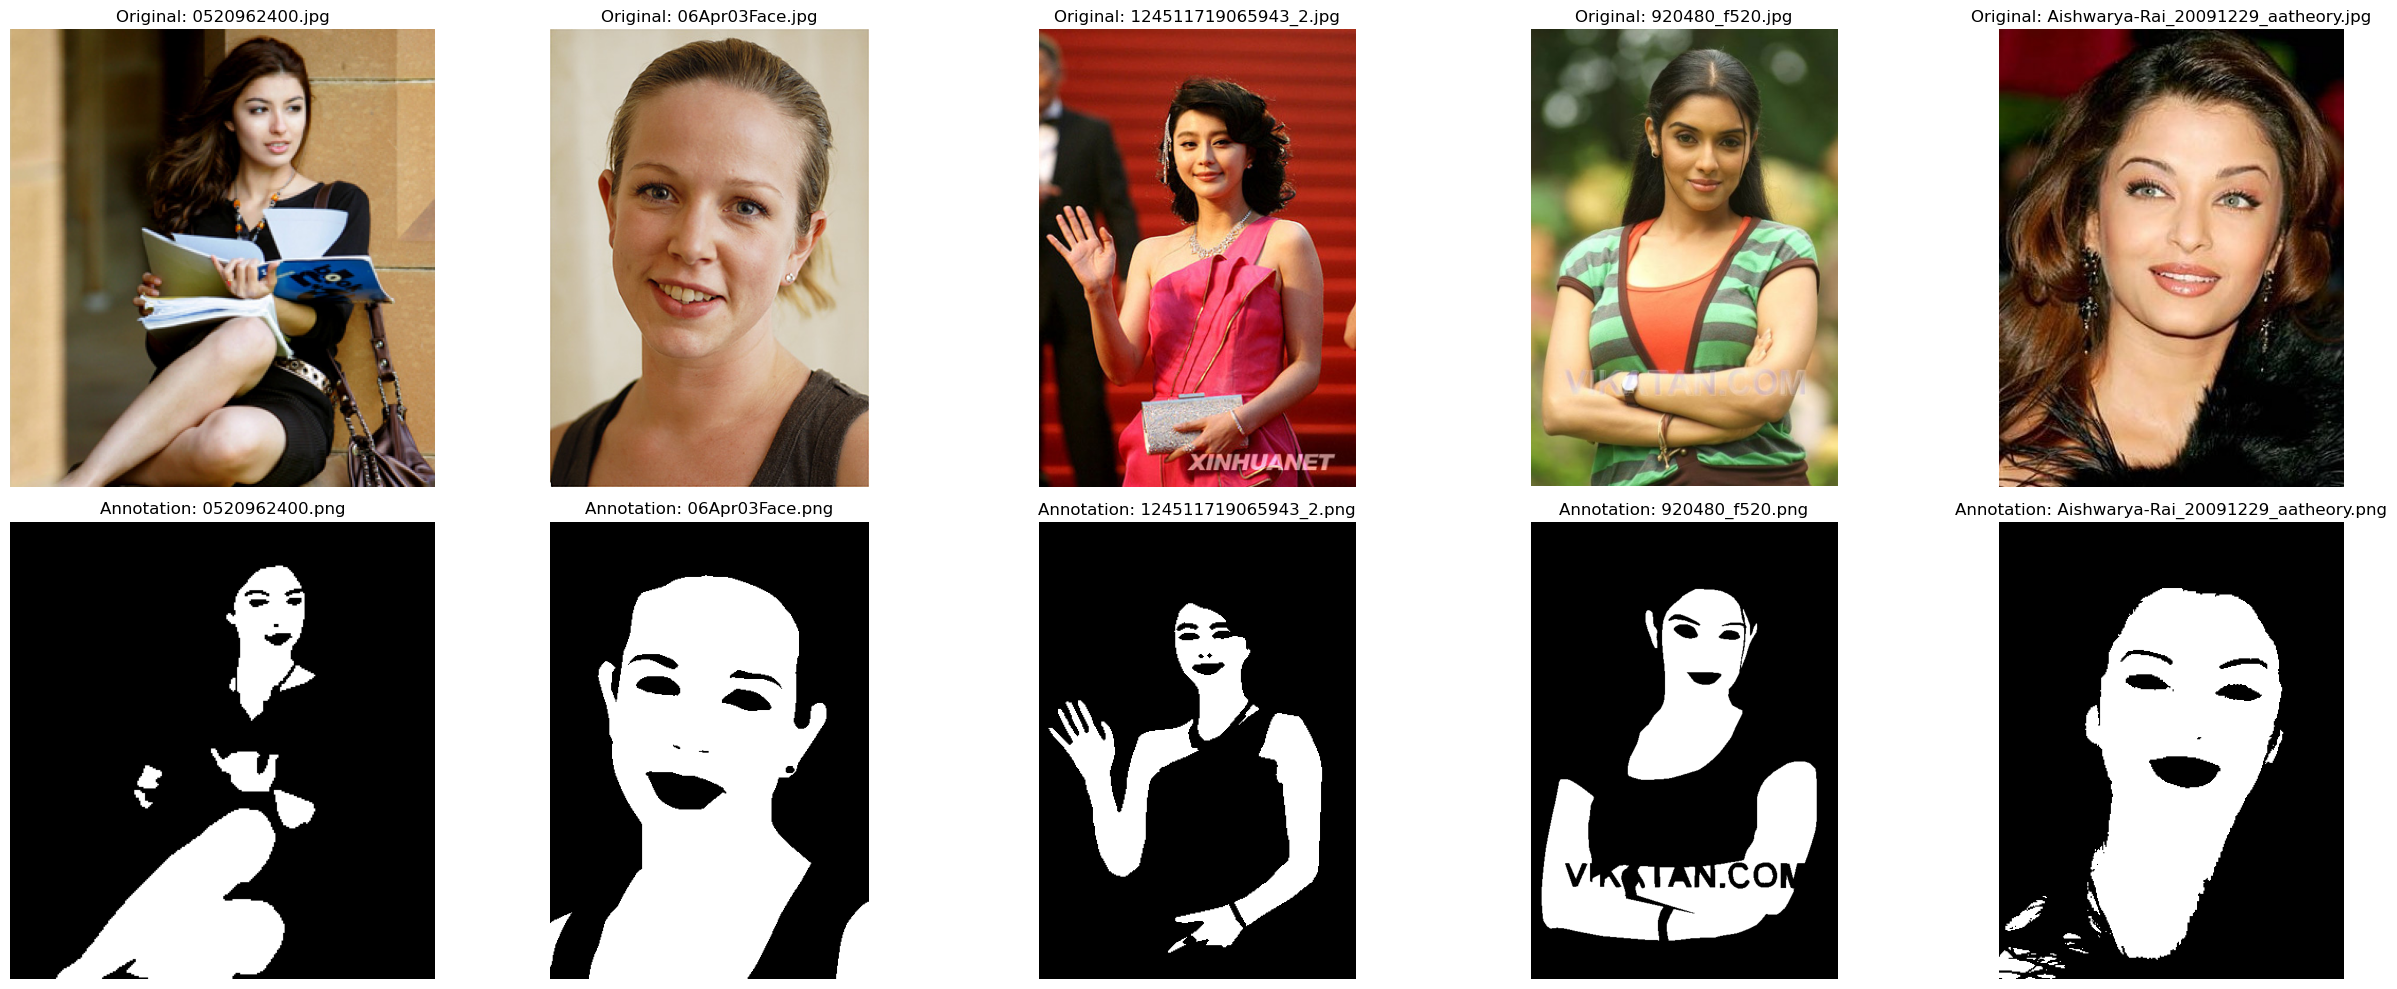

In [1]:
import os
import cv2
import matplotlib.pyplot as plt

# Đường dẫn đến thư mục chứa ảnh gốc và annotation của bộ Pratheepan (FacePhoto)
face_img_dir = "../dataset/Face_Dataset/Pratheepan_Dataset/FacePhoto"
face_mask_dir = "../dataset/Face_Dataset/Ground_Truth/GroundT_FacePhoto"

# Lấy danh sách các file ảnh (chỉ các file .jpg hoặc .png)
img_files = sorted([f for f in os.listdir(face_img_dir) if f.lower().endswith((".jpg", ".png"))])
mask_files = sorted([f for f in os.listdir(face_mask_dir) if f.lower().endswith((".jpg", ".png"))])

# Chọn 5 mẫu đầu tiên (nếu số file < 5 thì lấy tất cả)
num_samples = min(5, len(img_files), len(mask_files))
print(f"Hiển thị {num_samples} mẫu.")

# Tạo figure với 2 hàng và num_samples cột:
# Hàng đầu tiên: ảnh gốc, Hàng thứ hai: annotation mask.
fig, axs = plt.subplots(2, num_samples, figsize=(5 * num_samples, 10))

for i in range(num_samples):
    img_path = os.path.join(face_img_dir, img_files[i])
    mask_path = os.path.join(face_mask_dir, mask_files[i])

    # Đọc ảnh gốc sử dụng OpenCV (OpenCV đọc ảnh ở định dạng BGR)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Không thể load ảnh: {img_path}")
        continue
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Đọc annotation mask (ảnh grayscale)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"Không thể load mask: {mask_path}")
        continue

    # Hiển thị ảnh gốc trên hàng đầu tiên
    axs[0, i].imshow(img_rgb)
    axs[0, i].set_title(f"Original: {img_files[i]}")
    axs[0, i].axis("off")

    # Hiển thị annotation mask trên hàng thứ hai
    axs[1, i].imshow(mask, cmap="gray")
    axs[1, i].set_title(f"Annotation: {mask_files[i]}")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()
